# 1 - Import libs

In [6]:
import os
import subprocess
import pandas as pd

pd.set_option('display.max_columns',None)

# 2 - Funções

# 3 - Carrega base de dados

Aqui faço o download de alguns datasets disponíveis no Kaggle e escolho um para desenvolver o modelo.  

### Dataset escolhido - Synthetic Financial Datasets For Fraud Detection | PaySim  

#### Colunas do dataset:  

- step - mapeia uma unidade de tempo no mundo real. Neste caso, 1 step é 1 hora de tempo. Total de steps: 744 (simulação de 30 dias)  

- type - CASH-IN, CASH-OUT, DEBIT, PAYMENT e TRANSFER  

- amount - valor da transação na moeda local  

- nameOrig - cliente que iniciou a transação  

- oldbalanceOrg - saldo inicial antes da transação  

- newbalanceOrig - novo saldo após a transação  

- nameDest - cliente que é o destinatário da transação  

- oldbalanceDest - saldo inicial do destinatário antes da transação. Note que não há informações para clientes cujo nome começa com M (Mercadores)  

- newbalanceDest - novo saldo do destinatário após a transação. Note que não há informações para clientes cujo nome começa com M (Mercadores).  

- isFraud - Transações realizadas pelos agentes fraudulentos dentro da simulação. Neste conjunto de dados específico, o comportamento fraudulento dos agentes visa lucrar ao assumir o controle das contas dos clientes e tentar esvaziar os fundos transferindo para outra conta e, em seguida, retirando o dinheiro do sistema.  

- isFlaggedFraud - O modelo de negócios visa controlar transferências massivas de uma conta para outra e sinalizar tentativas ilegais. Uma tentativa ilegal neste conjunto de dados é uma tentativa de transferir mais de 200.000 em uma única transação.

Download dataset:  

In [15]:
# subprocess.run(["kaggle", "datasets", "download", "ealaxi/paysim1", "-p", "../data/raw", "--unzip"])

# 4 - Conhecendo o dataset

EDA - Exploratory data analysis.

In [ ]:
df = pd.read_csv('../data/raw/PS_20174392719_1491204439457_log.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [17]:
df.shape

(6362620, 11)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

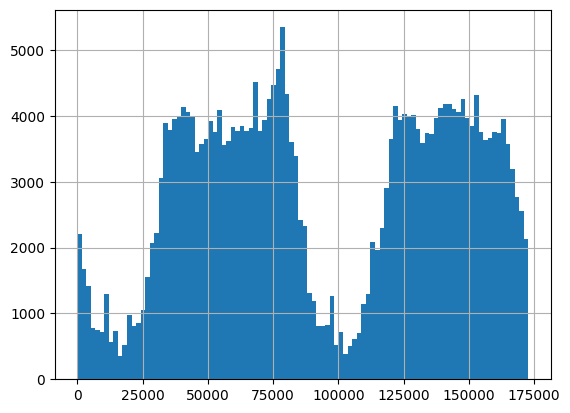

In [11]:
df['Time'].hist(bins=100);